# Project


Colorectal Liver Metastases Recurrence Prediction from Clinical and CT Image Data

# Preliminaries

In [1]:
import torch
import torch.nn as nn
from torchsummary import summary
import torchvision
import os
import gc
from tqdm import tqdm
from PIL import Image
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
import glob
import matplotlib.pyplot as plt
from torchvision import models
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Classification Dataset

In [3]:
config = {
    "batch_size": 32,
    "lr": 1e-3,
    "epochs": 30
}

In [4]:
DATA_DIR    = '/content/drive/MyDrive/dataset/'
TRAIN_DIR   = os.path.join(DATA_DIR, "train_whole") 
VAL_DIR     = os.path.join(DATA_DIR, "valid_whole")


train_transforms = torchvision.transforms.Compose([
    # torchvision.transforms.RandAugment(6),
    torchvision.transforms.RandomHorizontalFlip(),
    # torchvision.transforms.RandomRotation(10),
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    # torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=[0.20978874], std=[0.21695834]),
])

valid_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    # torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=[0.20978874], std=[0.21695834])
])

train_dataset   = torchvision.datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
valid_dataset   = torchvision.datasets.ImageFolder(VAL_DIR, transform=valid_transforms)

train_loader = torch.utils.data.DataLoader(
    dataset     = train_dataset, 
    batch_size  = config['batch_size'], 
    shuffle     = True,
    num_workers = 4, 
    pin_memory  = True
)

valid_loader = torch.utils.data.DataLoader(
    dataset     = valid_dataset, 
    batch_size  = config['batch_size'],
    shuffle     = False,
    num_workers = 2
)

/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
from collections import Counter
print(dict(Counter(train_dataset.targets)))

{0: 2763, 1: 9218}


In [6]:
from collections import Counter
print(dict(Counter(valid_dataset.targets)))

{0: 990, 1: 2400}


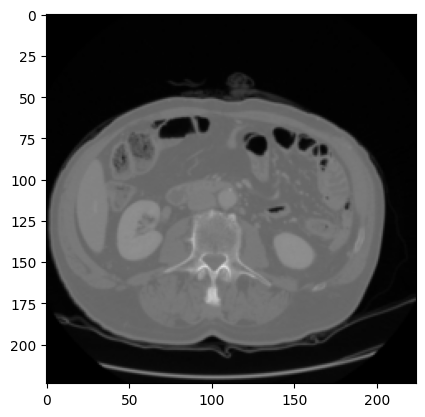

In [34]:
for i, (images, labels) in enumerate(valid_loader):
  plt.imshow(np.transpose(np.array(images[7]), (1, 2, 0)))
  # plt.imshow(np.transpose(np.array(images[1]), (1, 2, 0)))
  break

# Model

In [ ]:
from collections import OrderedDict

model_name = 'vgg16' #changeable
PRETRAINED = True #changeable

model = None #Don't touch

if model_name == 'vgg16':
    model = torchvision.models.vgg16(pretrained = PRETRAINED).to(DEVICE)
    
    if PRETRAINED:
        for param in model.parameters():
            param.requires_grad = False
            
    layers_vgg16 = nn.Sequential(OrderedDict([
            ('fc1', nn.Linear(25088, 512)),
            ('activation1', nn.ReLU()),
            ('dropout1', nn.Dropout(0.2)),
            ('fc2', nn.Linear(512, 256)),
            ('activation2', nn.ReLU()),
            ('dropout2', nn.Dropout(0.2)),
            ('fc3', nn.Linear(256, 128)),
            ('activation3', nn.ReLU()),
            ('dropout3', nn.Dropout(0.2)),
            ('fc4', nn.Linear(128, 2)),
            ('out', nn.Sigmoid())

        ])).to(DEVICE)
    model.classifier = layers_vgg16

assert(model is not None)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:01<00:00, 399MB/s]


In [18]:
cfg = {
    'A' : [64,     'M', 128,      'M', 256, 256,           'M', 512, 512,           'M', 512, 512,           'M'],
    'B' : [64, 64, 'M', 128, 128, 'M', 256, 256,           'M', 512, 512,           'M', 512, 512,           'M'],
    'D' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256,      'M', 512, 512, 512,      'M', 512, 512, 512,      'M'],
    'E' : [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M']
}

class VGG(nn.Module):

    def __init__(self, features, num_class=1):
        super().__init__()
        self.features = features

        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            # nn.Linear(25088,8),
            # nn.Sigmoid(),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            # nn.Linear(8,8),
            # nn.Sigmoid(),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(4096, num_class)
            # nn.Linear(8, num_class)
        )

    def forward(self, x):
        output = self.features(x)
        output = output.view(output.size()[0], -1)
        output = self.classifier(output)

        return output

def make_layers(cfg, batch_norm=False):
    layers = []

    input_channel = 3
    for l in cfg:
        if l == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            continue

        layers += [nn.Conv2d(input_channel, l, kernel_size=3, padding=1)]

        if batch_norm:
            layers += [nn.BatchNorm2d(l)]

        # layers += [nn.Sigmoid()]
        layers += [nn.ReLU(inplace=True)]
        input_channel = l

    return nn.Sequential(*layers)

model = VGG(make_layers(cfg['B'], batch_norm=True)).to(DEVICE)

# Setup everything for training

In [19]:
# criterion = torch.nn.BCEWithLogitsLoss()
# criterion = nn.CrossEntropyLoss()
criterion = torch.nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
optimizer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.5, patience=3)

# Let's train!

In [17]:
import torch.nn.functional as F
def train(model, dataloader, optimizer, criterion):
    
    model.train()

    batch_bar   = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5) 

    total_loss  = 0.0
    total_acc = 0.0
    num_correct = 0.0

    for i, (images, labels) in enumerate(dataloader):
        
        optimizer.zero_grad()
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        outputs = model(images)
        outputs = F.sigmoid(outputs)
        loss    = criterion(outputs, labels.unsqueeze(1).float())
        acc = (((outputs > 0.75) == labels).float().mean().item())*100
        # acc = binary_acc(outputs, labels.unsqueeze(1).float())
        # loss = criterion(outputs, labels)
        # num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())

        total_loss += float(loss.item())
        total_acc += float(acc)

        batch_bar.set_postfix(
            # acc         = "{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            acc         = "{:.04f}%".format(float(total_acc/len(dataloader))),
            loss        = "{:.04f}".format(float(total_loss / (i + 1))),
            lr          = "{:.04f}".format(float(optimizer.param_groups[0]['lr']))
        )
        
        loss.backward()
        optimizer.step()
      
        batch_bar.update()

    batch_bar.close()

    # acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    # total_loss = float(total_loss / len(dataloader))
    acc         = float(total_acc/len(dataloader))
    total_loss  = float(total_loss / len(dataloader))

    return acc, total_loss

In [16]:
def validate(model, dataloader, criterion):
  
    model.eval()
    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, position=0, leave=False, desc='Val', ncols=5)

    total_loss = 0.0
    total_acc = 0.0
    num_correct = 0.0
    test_results = []
    true_labels = []

    for i, (images, labels) in enumerate(dataloader):

        images, labels = images.to(DEVICE), labels.to(DEVICE)
        
        with torch.inference_mode():
            outputs = model(images)
            outputs = F.sigmoid(outputs)
            print(outputs)
            # loss = criterion(outputs, labels)
            loss    = criterion(outputs, labels.unsqueeze(1).float())
        acc = (((outputs > 0.75) == labels).float().mean().item())*100
        # acc = binary_acc(outputs, labels.unsqueeze(1).float())

        # num_correct += int((torch.argmax(outputs, axis=1) == labels).sum())
        total_loss += float(loss.item())
        total_acc += float(acc)

        outputs = torch.argmax(outputs, dim=1).detach().cpu().numpy().tolist()
        labels = labels.detach().cpu().numpy().tolist()
        test_results.extend(outputs > 0.75)
        true_labels.extend(labels)

        batch_bar.set_postfix(
            # acc="{:.04f}%".format(100 * num_correct / (config['batch_size']*(i + 1))),
            acc="{:.04f}%".format(float(total_acc/len(dataloader))),
            loss="{:.04f}".format(float(total_loss / (i + 1))))

        batch_bar.update()
        
    batch_bar.close()
    acc = float(total_acc/len(dataloader))
    total_loss = float(total_loss / len(dataloader))
    # acc         = 100 * num_correct / (config['batch_size']* len(dataloader))
    # total_loss = float(total_loss / len(dataloader))
    
    return acc, total_loss, test_results, true_labels

# Experiments

In [ ]:
best_valacc = 0

for epoch in range(config['epochs']):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    train_acc, train_loss = train(model, train_loader, optimizer, criterion)
    
    print("\nEpoch {}/{}: \nTrain Acc {:.04f}%\t Train Loss {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1,
        config['epochs'],
        train_acc,
        train_loss,
        curr_lr))
    
    val_acc, val_loss, test_results, true_labels = validate(model, valid_loader, criterion)
    
    print("Val Acc {:.04f}%\t Val Loss {:.04f}".format(val_acc, val_loss))
    scheduler.step(val_loss)
    gc.collect()
    torch.cuda.empty_cache()

Train:  19%|█▉        | 72/375 [00:41<02:39,  1.90it/s, acc=4.4589%, loss=0.6240, lr=0.0000]

Text(83.22222222222221, 0.5, 'Predicted class')

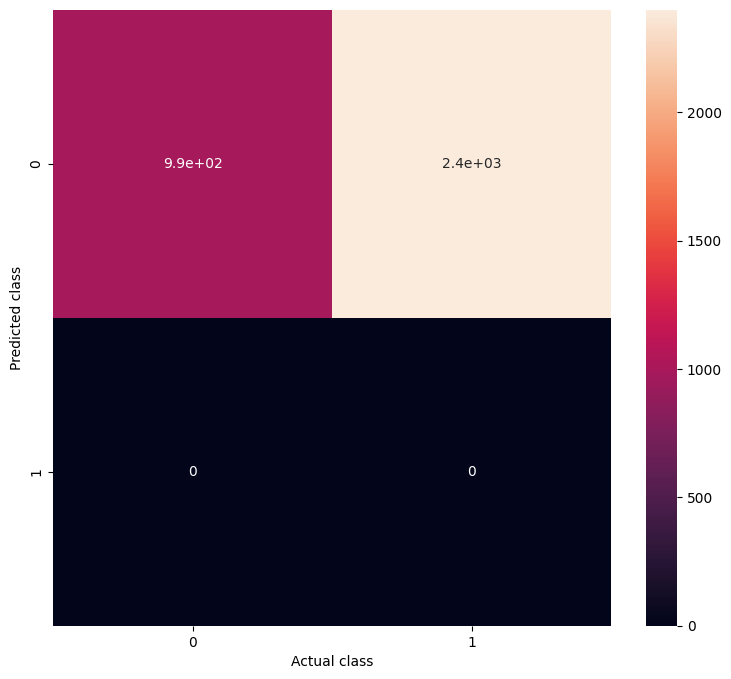

In [10]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# test_results, true_labels = test(model, valid_loader, criterion)

cm = confusion_matrix(test_results, true_labels)
plt.figure(figsize=(9, 8))
sns.heatmap(cm, annot=True)
plt.xlabel("Actual class")
plt.ylabel("Predicted class")